# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

In [3]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb
%run "Git.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_85256\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4621.28,1.00,-131.89,2436.33,2304.44
OMUSDT,526.32,3232.64,0.70,0.00,2706.32,2706.32
BTCUSDT,601.02,728.75,0.16,3.54,127.73,131.27
SOLUSDT,281.20,223.23,0.05,0.00,-57.97,-57.97
JASMYUSDT,387.46,172.32,0.04,0.00,-215.14,-215.14
ETHUSDT,250.75,132.78,0.03,0.00,-117.97,-117.97
TRXUSDT,76.87,116.15,0.03,-10.72,39.28,28.56
BBUSDT,60.18,14.33,0.00,-39.73,-45.85,-85.58
BNBUSDT,1.14,1.07,0.00,-10.61,-0.07,-10.68
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

473

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
push_or_update_file(positions,'Positions',repo_owner, repo_name, token, branch='main')

🔁 File exists. Will update (SHA: d74d999a13446757c0c9a83360c52ff33fbdc8ce)
✅ File pushed/updated successfully!


In [28]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [29]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [30]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [31]:
push_or_update_file(quantities,'Quantities',repo_owner, repo_name, token, branch='main')

🔁 File exists. Will update (SHA: 69c6817548551d8eda1f93caf45dfbaea8347730)
✅ File pushed/updated successfully!


In [32]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [33]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [34]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [35]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [36]:
# pnl_history['Total']

In [37]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [38]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [39]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [40]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [41]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-13    1981.620537
2025-03-14    2010.574081
2025-03-15    2202.769914
2025-03-16    2210.019473
2025-03-17    2485.773076
Name: Total, Length: 176, dtype: float64

In [42]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-13   -137.783248
2025-03-14     28.953544
2025-03-15    192.195833
2025-03-16      7.249559
2025-03-17    275.753603
Name: Total, Length: 176, dtype: float64

In [43]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-219.6118751223521, -334.9272908594338)

In [44]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [45]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [46]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [47]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [48]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [49]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [50]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

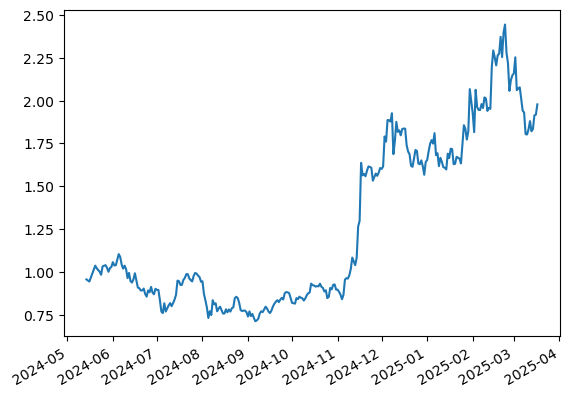

In [51]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

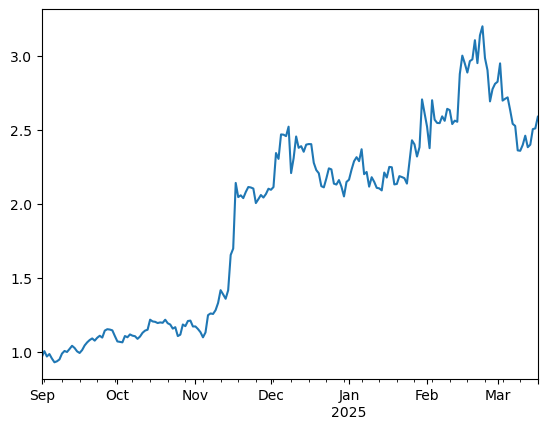

In [52]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [54]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [57]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [58]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [61]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.7784
OMUSDT,0.1376
AAVEUSDT,0.0350
BNBUSDT,0.0339
DEXEUSDT,0.0089
ADAUSDT,0.0062
BONKUSDT,0.0000
WLDUSDT,0.0000
INJUSDT,0.0000
LDOUSDT,0.0000


In [62]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.466953
BTCUSDT,0.300000
OMUSDT,0.233047


In [63]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

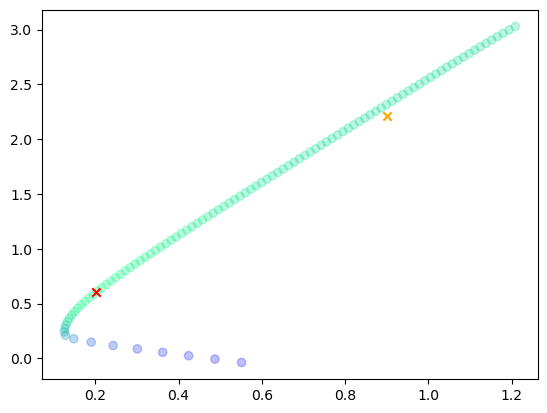

In [64]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [65]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [66]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3232.642289,0.699512,0.0637,0.635812
BTCUSDT,728.751010,0.157695,0.0000,0.157695
SOLUSDT,223.232446,0.048305,0.0000,0.048305
JASMYUSDT,172.320387,0.037288,0.0000,0.037288
ETHUSDT,132.778417,0.028732,0.0000,0.028732
TRXUSDT,116.153432,0.025135,0.0064,0.018735
BBUSDT,14.330341,0.003101,0.0000,0.003101
BNBUSDT,1.073288,0.000232,0.0665,-0.066268
PEPEUSDT,0.000002,0.000000,0.0032,-0.003200
PAXGUSDT,0.000000,0.000000,0.3983,-0.398300


### Current results

In [68]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [69]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.876562
OMUSDT,0.103791
TRXUSDT,0.019647


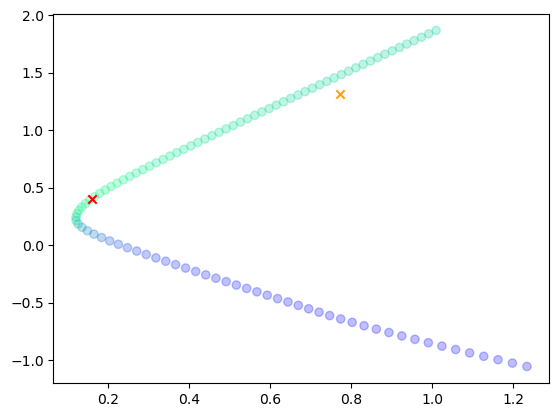

In [70]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [71]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3232.642289,0.699512,0.103791,0.595721
BTCUSDT,728.751010,0.157695,0.000000,0.157695
SOLUSDT,223.232446,0.048305,0.000000,0.048305
JASMYUSDT,172.320387,0.037288,0.000000,0.037288
ETHUSDT,132.778417,0.028732,0.000000,0.028732
TRXUSDT,116.153432,0.025135,0.019647,0.005488
BBUSDT,14.330341,0.003101,0.000000,0.003101
BNBUSDT,1.073288,0.000232,0.000000,0.000232
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.876562,-0.876562


# Risk Reward Analysis

In [73]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [74]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

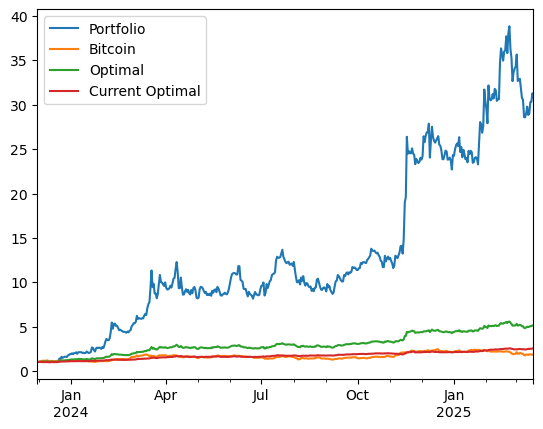

In [75]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [76]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

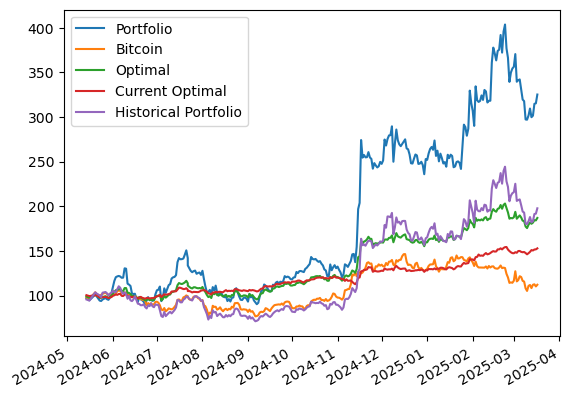

In [77]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [78]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-08,317.856157,115.682157,183.483859,148.798847,193.005673
2025-03-09,297.325475,108.074181,177.345892,147.643978,180.399004
2025-03-10,297.061972,105.172891,175.585692,146.197133,180.191407
2025-03-11,301.772384,110.822138,179.382363,147.469307,183.215484
2025-03-12,309.574435,111.816046,181.877026,148.925608,187.971314
2025-03-13,299.849339,108.335893,180.417689,150.952189,182.047066
2025-03-14,301.565508,112.099402,181.710682,150.459395,183.335317
2025-03-15,314.832655,112.572571,184.520126,151.599853,191.350939
2025-03-16,315.410107,110.193184,184.194272,151.743003,191.748673
2025-03-17,325.253996,112.092354,186.945450,152.860453,197.754476


## Volatilities

In [80]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.356075
 dtype: float64,
 0.35644092910920416)

In [81]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.772142
 dtype: float64,
 0.772141627230972)

In [82]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.899881
Bitcoin            0.433817
Optimal            0.356441
Current Optimal    0.176389
dtype: float64

In [83]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4690606667707048

In [84]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.752710191502707

In [85]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7054503451357161

## Risk Contribution

In [87]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.248866,0.300000,0.027078,0.231709,0.133315,0.098394
OMUSDT,18.791957,0.233047,0.938598,0.723625,0.624548,0.099077
PAXGUSDT,0.228775,0.466953,0.034324,0.044666,0.028507,0.016159


In [88]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.470923,0.103791,0.328777,0.481228,0.429831,0.051397
TRXUSDT,0.007522,0.019647,0.015543,0.025626,0.009323,0.016302
PAXGUSDT,0.269589,0.876562,0.655680,0.493146,0.452609,0.040537


In [89]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.144608,0.693069,0.930345,0.891763,0.821846,0.069918
BTCUSDT,0.027996,0.158416,0.045191,0.041799,0.007328,0.034471
SOLUSDT,-0.019487,0.049505,0.007277,0.023956,0.002219,0.021737
JASMYUSDT,-0.025487,0.039604,0.003422,0.024966,0.003186,0.021781
ETHUSDT,-0.013998,0.029703,0.003807,0.009207,0.000494,0.008713
TRXUSDT,0.011372,0.029703,0.009958,0.008307,0.000914,0.007393


# Value At Risk

## Historical

### Optimal Weights

In [93]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.02854061558312477, -0.040163107655131154)

### Current Weights

In [95]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05601497496786634, -0.08164182196393893)

In [96]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [97]:
var=historical_var.iloc[row]
var

OMUSDT      -0.044345
BTCUSDT     -0.006764
SOLUSDT     -0.001477
JASMYUSDT   -0.002143
ETHUSDT     -0.002282
TRXUSDT      0.000212
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.056799
Name: 2024-08-04 00:00:00, dtype: float64

In [98]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.066171
BTCUSDT     -0.005688
SOLUSDT     -0.003642
JASMYUSDT   -0.003526
ETHUSDT     -0.001683
TRXUSDT     -0.000933
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.081642
dtype: float64

## Parametric

### Optimal Weights

In [101]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.03693299722888643, -0.047337891039239736)

### Current Weights

In [103]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08000625699775442, -0.10254590096616706)

## Multivariate

### Optimal Weights

In [106]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0331274394427516, -0.0428645556929724)

### Current Weights

In [108]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07355379860877034, -0.09416727638675595)

In [109]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.067358
BTCUSDT     -0.002595
SOLUSDT     -0.001583
JASMYUSDT   -0.001935
ETHUSDT     -0.000626
TRXUSDT     -0.000739
Portfolio   -0.074836
dtype: float64

In [110]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.067457
BTCUSDT     -0.002468
SOLUSDT     -0.001631
JASMYUSDT   -0.002242
ETHUSDT     -0.000716
TRXUSDT     -0.001033
Portfolio   -0.075548
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [114]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03279112758047299, -0.04219018875592409)

### Current Weights

In [116]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07553218556729371, -0.09543933203276776)

In [117]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [120]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03299870890229043, -0.04221821599567579)

### Current Weights

In [122]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07496846956179351, -0.0974180571247008)

In [123]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [126]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06814489378953226, -0.09376837428555335)

### Current Weights

In [128]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15593254141807572, -0.21964192930827278)

In [129]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [132]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [133]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03828683834308009, -0.04815274212240834)

### Current Weights

In [135]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08336971512697293, -0.10287402257947954)

In [136]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [137]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.156360,-0.065230,-0.071934,-0.067358,-0.066740
BTCUSDT,-0.000379,-0.003554,-0.003871,-0.002595,-0.003783
SOLUSDT,0.000520,-0.002316,-0.002150,-0.001583,-0.001973
JASMYUSDT,-0.000510,-0.002110,-0.002219,-0.001935,-0.001961
ETHUSDT,-0.000043,-0.000900,-0.000799,-0.000626,-0.000994
TRXUSDT,0.000249,-0.000679,-0.000740,-0.000739,-0.000651
Portfolio,-0.156522,-0.074788,-0.081712,-0.074836,-0.076102


In [138]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.160412,-0.065413,-0.071461,-0.067457,-0.068030
BTCUSDT,0.000333,-0.003721,-0.004360,-0.002468,-0.003428
SOLUSDT,0.001113,-0.002398,-0.002463,-0.001631,-0.001778
JASMYUSDT,-0.000603,-0.002545,-0.002203,-0.002242,-0.001972
ETHUSDT,-0.000024,-0.000873,-0.000982,-0.000716,-0.000988
TRXUSDT,0.000296,-0.000716,-0.000988,-0.001033,-0.000650
Portfolio,-0.159296,-0.075667,-0.082457,-0.075548,-0.076846


## VaR Violation

In [140]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028979,-0.054429,-0.046003,-0.011888
2024-01-15,-0.028979,-0.054433,-0.044853,0.012411
2024-01-16,-0.028979,-0.054495,-0.044793,0.025121
2024-01-17,-0.028979,-0.055878,-0.048137,-0.019937
2024-01-18,-0.028979,-0.056780,-0.049214,-0.015654
...,...,...,...,...
2025-03-14,-0.038956,-0.046524,-0.048837,0.007167
2025-03-15,-0.038956,-0.047014,-0.047720,0.015461
2025-03-16,-0.038956,-0.043491,-0.045453,-0.001766
2025-03-17,-0.038956,-0.043438,-0.043902,0.014936


In [141]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045314,-0.083588,-0.080903,-0.014975
2024-05-29,-0.045314,-0.081518,-0.080142,-0.007055
2024-05-30,-0.045314,-0.071879,-0.072645,0.025496
2024-05-31,-0.045314,-0.076063,-0.072147,0.049178
2024-06-01,-0.045314,-0.082962,-0.077625,0.066874
...,...,...,...,...
2025-03-14,-0.080919,-0.078370,-0.088152,0.005723
2025-03-15,-0.080919,-0.083818,-0.090121,0.043994
2025-03-16,-0.080919,-0.083631,-0.091365,0.001834
2025-03-17,-0.080919,-0.081875,-0.089234,0.031210


<Axes: >

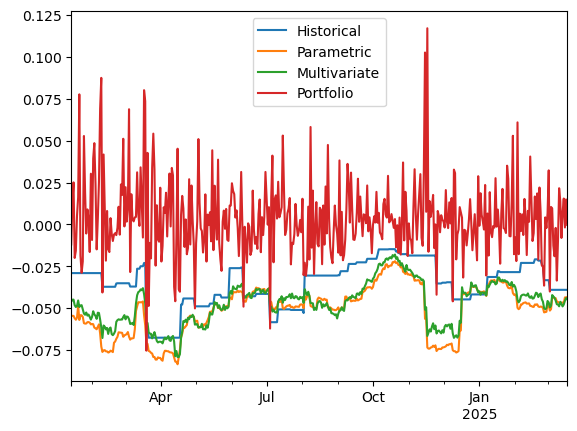

In [142]:
var_data.plot()

<Axes: >

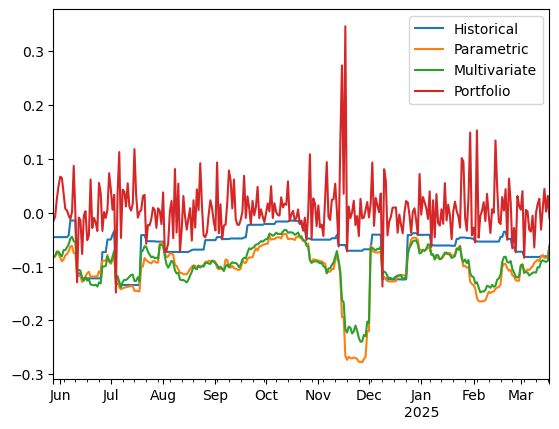

In [143]:
current_var_data.plot()

In [144]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032558,0.006977,0.006977
Kupiec Stat,3.124987,26.008809,26.008809
P-value,0.0771,0.0,0.0


In [145]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064407,0.010169,0.010169
Kupiec Stat,1.186224,14.430112,14.430112
P-value,0.276093,0.000145,0.000145


# Principal Component Analysis

## Historical PCA

In [148]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.8118448 , 0.0566017 , 0.04975902, 0.04665643, 0.03513805])

In [149]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017611
ADAUSDT      0.019006
ALGOUSDT     0.020043
APTUSDT      0.017732
ARBUSDT      0.019358
ATOMUSDT     0.017529
AVAXUSDT     0.019534
BCHUSDT      0.015598
BNBUSDT      0.009158
BONKUSDT     0.024003
BTCUSDT      0.009889
CAKEUSDT     0.018390
DEXEUSDT     0.013648
DOGEUSDT     0.018815
DOTUSDT      0.018058
EOSUSDT      0.018323
ETCUSDT      0.016408
ETHUSDT      0.013493
FDUSDUSDT    0.000051
FETUSDT      0.023006
FILUSDT      0.019866
FLOWUSDT     0.019276
GALAUSDT     0.023452
GRTUSDT      0.021640
HBARUSDT     0.018954
ICPUSDT      0.017866
IMXUSDT      0.019978
INJUSDT      0.020994
IOTAUSDT     0.021270
JASMYUSDT    0.021301
LDOUSDT      0.020672
LINKUSDT     0.017823
LTCUSDT      0.013345
MKRUSDT      0.013099
NEARUSDT     0.021586
NEXOUSDT     0.011557
OMUSDT       0.010946
OPUSDT       0.019891
PAXGUSDT     0.000261
PEPEUSDT     0.024525
QNTUSDT      0.015579
SANDUSDT     0.021536
SEIUSDT      0.021276
SHIBUSDT     0.018386
SOLUSDT      0.016469
STXUSDT   

<Axes: >

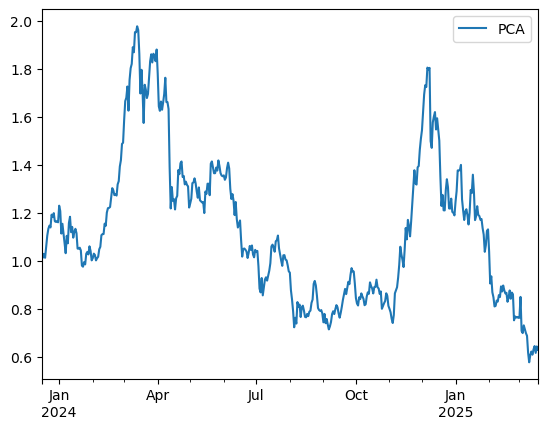

In [150]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

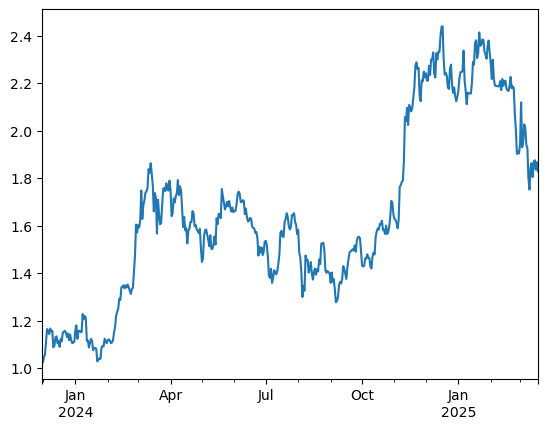

In [151]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [152]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426229
WBETHUSDT    0.461567
ETHUSDT      0.461962
ATOMUSDT     0.474756
DOTUSDT      0.477717
ETCUSDT      0.490103
NEXOUSDT     0.514218
EOSUSDT      0.530937
AVAXUSDT     0.547955
BTCUSDT      0.550783
WBTCUSDT     0.550820
FILUSDT      0.565795
IOTAUSDT     0.567212
ARBUSDT      0.580663
GRTUSDT      0.582270
XTZUSDT      0.583084
LINKUSDT     0.609504
VETUSDT      0.612138
IMXUSDT      0.623279
dtype: float64

<Axes: >

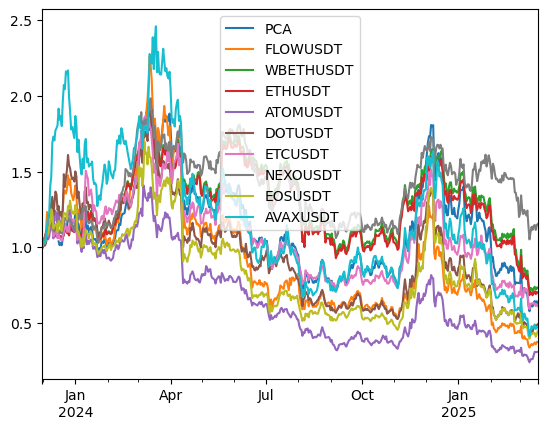

In [153]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

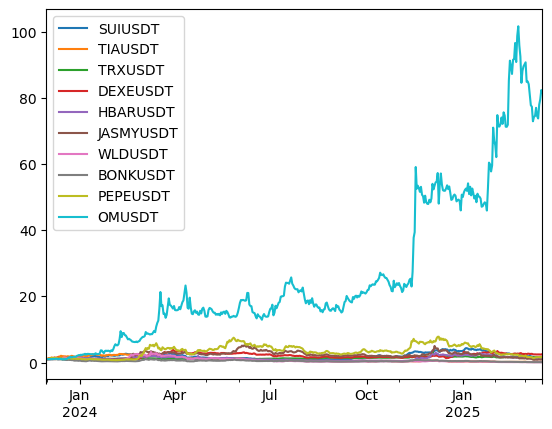

In [154]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [156]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59665713, 0.14076372, 0.10923427, 0.08837167, 0.06497321])

In [157]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088339
BTCUSDT      0.061213
SOLUSDT      0.108109
JASMYUSDT    0.172670
ETHUSDT      0.089052
TRXUSDT      0.050920
BBUSDT       0.197890
BNBUSDT      0.065756
PEPEUSDT     0.163182
PAXGUSDT     0.002868
Name: PC1, dtype: float64

<Axes: >

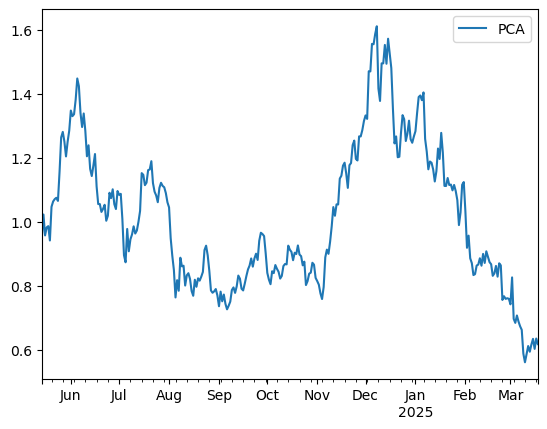

In [158]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

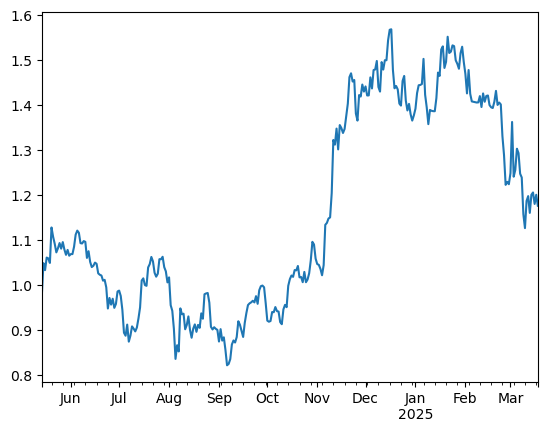

In [159]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [160]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.450054
BNBUSDT      0.506851
BTCUSDT      0.515369
SOLUSDT      0.526951
JASMYUSDT    0.707018
PEPEUSDT     0.761037
PAXGUSDT     0.782090
BBUSDT       0.807142
TRXUSDT      0.950989
dtype: float64

<Axes: >

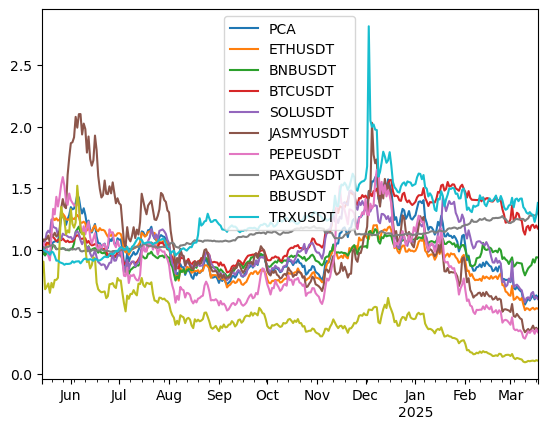

In [161]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [163]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.882235
BBUSDT       1.580025
JASMYUSDT    1.379721
SOLUSDT      1.240637
ETHUSDT      1.012075
BTCUSDT      1.000000
OMUSDT       0.875372
BNBUSDT      0.669170
TRXUSDT      0.337834
PAXGUSDT     0.037290
Name: BTCUSDT, dtype: float64

In [164]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.842674
PEPEUSDT     1.650213
JASMYUSDT    1.588906
BBUSDT       1.375128
ETHUSDT      1.303786
BTCUSDT      1.000000
BNBUSDT      0.678243
OMUSDT       0.633317
TRXUSDT      0.402051
PAXGUSDT     0.026380
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [166]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [167]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.232563
ETHUSDT,0.203693
BTCUSDT,0.180600
BBUSDT,0.163792
JASMYUSDT,0.138624
SOLUSDT,0.096085
PEPEUSDT,0.077828
TRXUSDT,0.071847
OMUSDT,-0.069688
PAXGUSDT,-0.261535


### Regression to PCA

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.0455380084572687

In [170]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.298540
BNBUSDT      1.163199
ETHUSDT      1.000328
PCA          1.000000
PAXGUSDT     0.741186
SOLUSDT      0.709231
JASMYUSDT    0.471228
PEPEUSDT     0.438421
BBUSDT       0.408850
TRXUSDT      0.283496
OMUSDT       0.249926
dtype: float64

In [171]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.412448
BTCUSDT      1.338337
PCA          1.000000
ETHUSDT      0.956460
TRXUSDT      0.881176
JASMYUSDT    0.776722
BBUSDT       0.677049
SOLUSDT      0.644517
PEPEUSDT     0.641894
OMUSDT       0.637365
PAXGUSDT    -0.114996
dtype: float64

### Correlation Matrix

<Axes: >

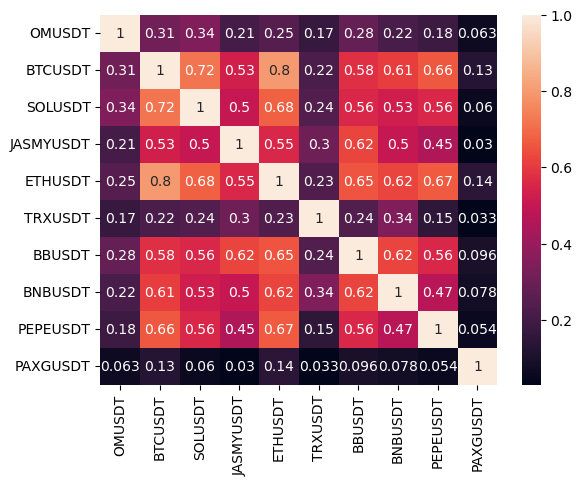

In [173]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

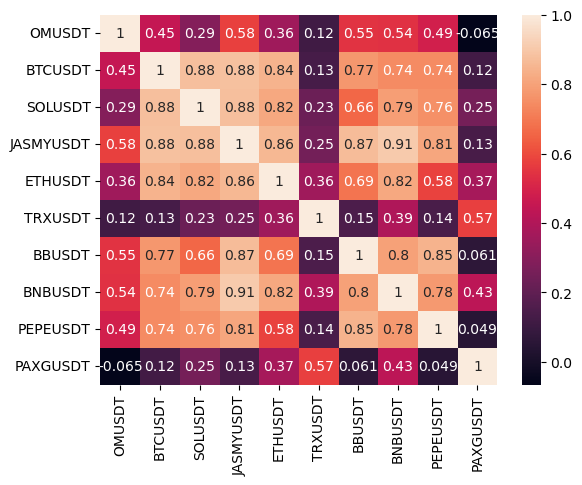

In [174]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [176]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [177]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-10,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802984,0.0
2024-09-09,0.05306,0.007964,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.135553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.320535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.00000,0.008643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223762,0.0
2025-01-07,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-06,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-08,0.00000,0.092123,0.0,0.0,0.0,0.0,0.0,0.261892,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-18,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [178]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.875107
OMUSDT      0.097810
CAKEUSDT    0.025073
ADAUSDT     0.002012
SOLUSDT     0.000000
LTCUSDT     0.000000
Name: 2025-03-18 00:00:00, dtype: float64

In [179]:
create_or_replace_notebook("Prod.ipynb", repo_owner, repo_name, token)

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
